RoughPy is a package for working with streaming data as rough paths, and working with algebraic objects such as free tensors, shuffle tensors, and elements of the free Lie algebra. 

In [1]:
# import pytest
import numpy as np
from numpy.testing import assert_array_almost_equal
import torch
import torch.nn as nn
import pickle
from utils import load_obj
import matplotlib.pyplot as plt

RoughPy is a package for viewing streams of data through the lens of rough paths and using the tools and techniques of signatures. In keeping with the style used by NumPy and other scientific Python libraries, we usually import RoughPy with the short name rp:

In [2]:
import roughpy as rp

Let's load the training data

In [3]:
x_real = torch.tensor(load_obj("./long_s_path.pkl"))
x_real_increments = x_real[:,1:,:] - x_real[:,:-1,:]

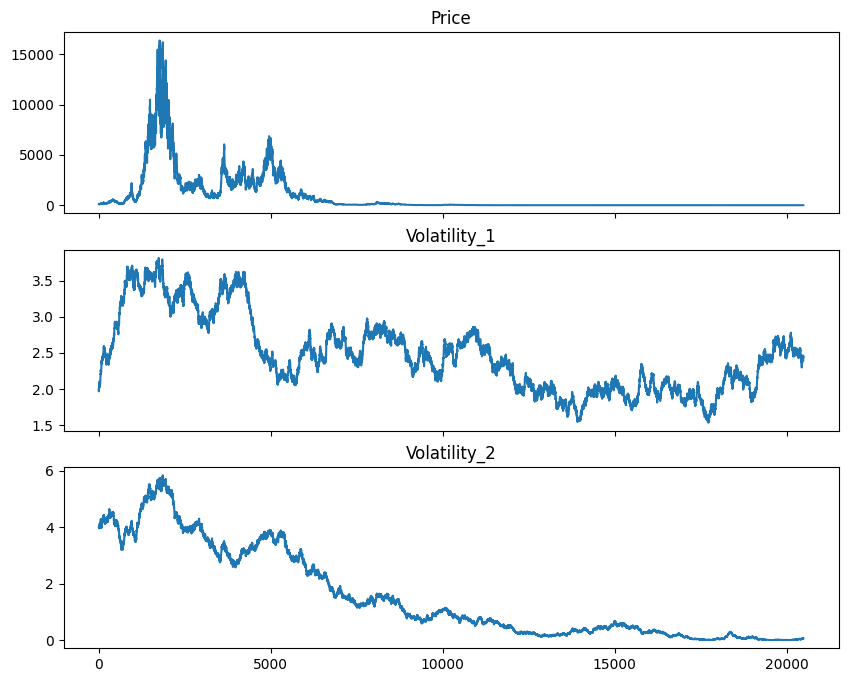

In [4]:
fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
titles = ["Price", "Volatility_1", "Volatility_2"]
for i in range(x_real.shape[2]):
    axs[i].plot(x_real[0, :, i].cpu().numpy())
    axs[i].set_title(f"{titles[i]}")

In [5]:
x_real_increments.shape

torch.Size([1, 20480, 3])

Before we can construct a RoughPy Stream object, we need to fix the width, depth, and coefficient type. The width refers to the dimension of the vector space in which our stream takes its values. The depth refers to the level at which signatures and log-signatures should be truncated. The coefficient type describes the type of scalars that are used in calculations, in this case, we use floating point number such as double precision (``rp.DPReal``). 

The collection of these three parameters is usually collected together into an ``AlgebraContext``, which is constructed as follows:

In [6]:
ctx = rp.get_context(width=3, depth=2, coeffs=rp.DPReal)

A stream in ``RoughPy`` is constructed using the ``LieIncrementStream``, and the ``from_increments`` constructor function. We assume the data is sampled in the interval [0, 10]

In [7]:
stream = rp.LieIncrementStream.from_increments(x_real_increments[0], ctx=ctx)

The main thing you can do with a stream is to query its signature or log-signature over a given interval.

In [8]:
interval = rp.RealInterval(15000, 15100)
sig = stream.signature(interval)

The signature is a `FreeTensor` object, which represents an element of the tensor algebra over $\mathbb{R}^\textrm{width}$ truncated at `depth`. It can be printed directly to the console, and to access individual entries we index it with a `TensorKey`. A convenient way to enumerate all tensor keys is `ctx.tensor_basis`:

In [9]:
print(f"sig = {sig}\n")

for key in ctx.tensor_basis:
    print(f"sig[{key}] = {sig[key]}")

sig = { 1() -0.169859(1) -0.0164464(2) -0.0913243(3) 0.014426(1,1) 0.0147203(1,2) -0.00245333(1,3) -0.0119268(2,1) 0.000135241(2,2) -0.00736838(2,3) 0.0179655(3,1) 0.00887033(3,2) 0.00417007(3,3) }

sig[()] = 1
sig[(1)] = -0.169859
sig[(2)] = -0.0164464
sig[(3)] = -0.0913243
sig[(1,1)] = 0.014426
sig[(1,2)] = 0.0147203
sig[(1,3)] = -0.00245333
sig[(2,1)] = -0.0119268
sig[(2,2)] = 0.000135241
sig[(2,3)] = -0.00736838
sig[(3,1)] = 0.0179655
sig[(3,2)] = 0.00887033
sig[(3,3)] = 0.00417007


Alternatively, we can transform the signature into the a numpy array, however, we lose the information about the ``tensor_basis``.

In [10]:
sig_float = np.array(sig)
sig_float

array([ 1.00000000e+00, -1.69858605e-01, -1.64463520e-02, -9.13243294e-02,
        1.44259728e-02,  1.47203158e-02, -2.45332576e-03, -1.19267614e-02,
        1.35241247e-04, -7.36837664e-03,  1.79655489e-02,  8.87032871e-03,
        4.17006657e-03])

Similarly, we can compute the log-signature, a log-signature is a lie polynomial, which in roughpy is represented as a `Lie` object. Finding a basis of the space of (truncated) Lie polynomials is not an obvious (or unique) task, and the basis used internally by roughpy can be accessed using `ctx.lie_basis` in a similar way to the tensor basis.

In [11]:
log_sig = stream.log_signature(interval)

In [12]:
print(f"log sig = {log_sig}\n")

for i, key in enumerate(ctx.lie_basis):
    print(f"log_sig[{key}] = {log_sig[i+1]}")

log sig = { -0.169859(1) -0.0164464(2) -0.0913243(3) 0.0133235([1,2]) -0.0102094([1,3]) -0.00811935([2,3]) }

log_sig[1] = -0.169859
log_sig[2] = -0.0164464
log_sig[3] = -0.0913243
log_sig[[1,2]] = 0.0133235
log_sig[[1,3]] = -0.0102094
log_sig[[2,3]] = -0.00811935


In [13]:
lie_basis = ctx.lie_basis
for i, key in enumerate(lie_basis):
    assert str(lie_basis.index_to_key(i)) == str(key)
    print(f"Key number {i}: {key}")

Key number 0: 1
Key number 1: 2
Key number 2: 3
Key number 3: [1,2]
Key number 4: [1,3]
Key number 5: [2,3]


An alternative to calling `log_signature()` on the stream would have been to directly take the logarithm of the signature. Class methods of `FreeTensor` include `log()` and `exp()`, which refer to the logarithm and exponential in the tensor algebra. The result is always another `FreeTensor`, and conversion into `Lie`s is possible with a class method of the context.

In [14]:
log_sig_as_tensor = sig.log()
log_sig2 = ctx.tensor_to_lie(log_sig_as_tensor)

for i, key in enumerate(lie_basis):
    # entries in FreeTensor's and Lie's are of type `rp.Scalar` and can be converted to python floats using `to_float()`
    assert np.isclose(log_sig[i+1].to_float(), log_sig2[i+1].to_float())

The same conversion can be made in the opposite direction.

In [15]:
log_sig_as_tensor2 = ctx.lie_to_tensor(log_sig)
tensor_basis = ctx.tensor_basis
for key in tensor_basis:
    assert np.isclose(log_sig_as_tensor[key].to_float(), log_sig_as_tensor2[key].to_float())